# Eight Schools: object oriented / automatic log joint

## Why?
Edward2 / TFD are really great and different applications will call for higher or lower level abstractions. Data scientists operate across a spectrum of modeling requirements from exploratory analysis to more in depth experimentation and analysis productionization. 

For many, exploratory analysis and modeling can be a large part of their work. Velocity is particularly important in this setting where the data scientist might repeatedly tweak a model and inspect its output. Furthermore, many do not have significant experience with Python (let alone TF). As such, this notebook seeks to address a few desiderata:

- Tweaking should be simple and fast: changes to the model should require minimal changes elsewhere (few to no manual changes to the log joint prob function, sampling code, etc.)
- Minimal knowledge of TF required while retaining flexibility for more advanced users.
- Hide details when appropriate, expose flexibility on demand. The user may not know much about Bayesian stats or sampling methods, but can define a model and just wants to get plots and diagnostics quicky. On the other hand, the user should be able to access the log joint prob function and apply their own sampling routine if they want (or dive down to Edward2 / TFD).

## What's different here?
- Drawing inspiration from PyTorch and TF Eager conventions, models are defined as classes. Like TF Eager, the user implements a `call` function for the generative process that makes the model instance callable.
- Using OO / metaclasses makes things like reflection easier in Python. This allows one to automatically create a log joint probability function by keeping track of which variables are observed and unobserved.
- Automatic creation of the log joint means we can do nice things like this:

```
# define Model here
model = Model(observed_data)
trace = sample(model) # ideally default to e.g. NUTS in the future + multiple chains / diagnostics
```

Going forward, this enables more turn-key analysis -- define your model, feed it into a sample function that auto-tunes the sampler, runs multiple chains, and returns diagnostics and traces in a format amenable to visualization.


Compare to [Eight_Schools.ipynb](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Eight_Schools.ipynb).

>[Eight Schools: object oriented / automatic log joint](#scrollTo=-Kcs3_9TL4bh)

>>[Why?](#scrollTo=-Kcs3_9TL4bh)

>>[What's different here?](#scrollTo=-Kcs3_9TL4bh)

>[Model Definition](#scrollTo=jiwZicYe7w3f)

>>>[The model keeps track of observed and unobserved variables.](#scrollTo=JTgbqLk6kFPt)

>[Criticism](#scrollTo=N20sU1Jb_9Tn)

>[Flexibility: sample using the model log joint directly](#scrollTo=L4EsfNFNZWt8)

>[Appendix: Bonus Example -- Tumors in Rats](#scrollTo=Vq2F-RVdbB7-)


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import edward2 as ed
tfd = tfp.distributions
# tf.enable_eager_execution()

In [0]:
#Model Class Source
import copy
import collections


class MetaModel(type):

  def __call__(cls, *args, **kwargs):
    obj = type.__call__(cls, *args, **kwargs)
    obj._load_observed()
    obj._load_unobserved()
    return obj


class BaseModel(object):
  __metaclass__ = MetaModel

  def _load_unobserved(self):
    unobserved_fun = self._unobserved_vars()
    self.unobserved = unobserved_fun()

  def _load_observed(self):
    self.observed = copy.copy(vars(self))

  def _unobserved_vars(self):

    def unobserved_fn(*args, **kwargs):
      unobserved_vars = collections.OrderedDict()

      def interceptor(f, *args, **kwargs):
        name = kwargs.get("name")
        rv = f(*args, **kwargs)
        if name not in self.observed:
          unobserved_vars[name] = rv.shape
        return rv

      with ed.interception(interceptor):
        self.__call__()
      return unobserved_vars

    return unobserved_fn
  
#   def observe(self, states):
#     for name, value in states.iteritems():
#       setattr(self, name, value)

  def target_log_prob_fn(self, *args, **kwargs):
    """Unnormalized target density as a function of unobserved states."""

    def log_joint_fn(*args, **kwargs):
      states = dict(zip(self.unobserved, args))
      states.update(self.observed)
      log_probs = []

      def interceptor(f, *args, **kwargs):
        name = kwargs.get("name")
        for name, value in states.iteritems():
          if kwargs.get("name") == name:
            kwargs["value"] = value
        rv = f(*args, **kwargs)
        log_prob = tf.reduce_sum(rv.distribution.log_prob(rv.value))
        log_probs.append(log_prob)
        return rv

      with ed.interception(interceptor):
        self.__call__()
      log_prob = sum(log_probs)
      return log_prob

    return log_joint_fn

  def get_posterior_fn(self, states={}, *args, **kwargs):
    """Get the log joint prob given arbitrary values for vars"""

    def posterior_fn(*args, **kwargs):

      def interceptor(f, *args, **kwargs):
        name = kwargs.get("name")
        for name, value in states.iteritems():
          if kwargs.get("name") == name:
            kwargs["value"] = value
        rv = f(*args, **kwargs)
        return rv

      with ed.interception(interceptor):
        return self.__call__()

    return posterior_fn

  def __call__(self):
    return self.call()

  def call(self, *args, **kwargs):
    raise NotImplementedError


# This is a really quick / hacky sample function.
# Ideally the user could choose the kernel or inference method
# e.g., I could imagine a user defining a variational approximation in the model
# and then using VI as a sample option here where the sample method looks for
# model.q()
# Also, it's relatively straightforward to see how one could return arbitrary
# diagnostics given the model.
# Todo: Add diagnostics, multiple chains, more automatic inference.
def sample(model,
           num_results=5000,
           num_burnin_steps=3000,
           step_size=.4,
           num_leapfrog_steps=3,
           numpy=True):
  initial_state = []
  for name, shape in model.unobserved.iteritems():
    initial_state.append(.5 * tf.ones(shape, name="init_{}".format(name)))

  states, kernel_results = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      kernel=tfp.mcmc.HamiltonianMonteCarlo(
          target_log_prob_fn=model.target_log_prob_fn(),
          step_size=step_size,
          num_leapfrog_steps=num_leapfrog_steps))

  if numpy:
    with tf.Session() as sess:
      states, is_accepted_ = sess.run([states, kernel_results.is_accepted])
      accepted = np.sum(is_accepted_)
      print("Acceptance rate: {}".format(accepted / num_results))
  return dict(zip(model.unobserved.keys(), states))

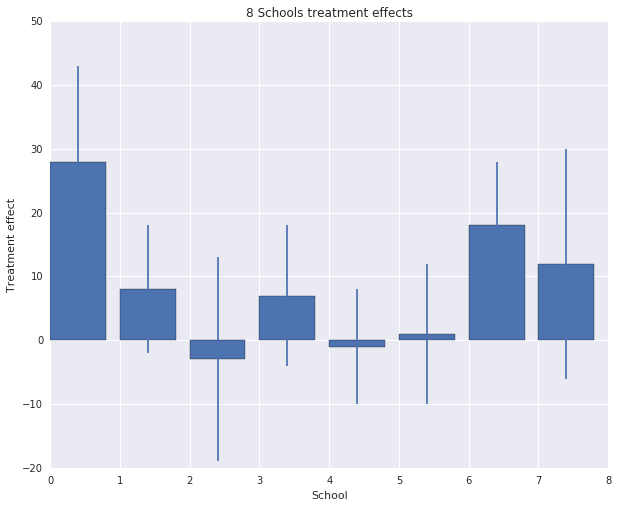

In [0]:
num_schools = 8  # number of schools
treatment_effects = np.array(
    [28, 8, -3, 7, -1, 1, 18, 12], dtype=np.float32)  # treatment effects
treatment_stddevs = np.array(
    [15, 10, 16, 11, 9, 11, 10, 18], dtype=np.float32)  # treatment SE

fig, ax = plt.subplots()
plt.bar(range(num_schools), treatment_effects, yerr=treatment_stddevs)
plt.title("8 Schools treatment effects")
plt.xlabel("School")
plt.ylabel("Treatment effect")
fig.set_size_inches(10, 8)
plt.show()

# Model Definition

The model is created as a class which inherits from some BaseModel class. Observed data is given as arguments at initialization and saved as instance variables (instead of being passed as function arguments).

The generative model itself is defined in `call`. This method is invoked when the instance is called, e.g., `model()`. 

In [0]:
class Model(BaseModel):

  def __init__(self, num_schools, treatment_stddevs, treatment_effects):
    super(BaseModel, self).__init__()
    self.num_schools = num_schools
    self.treatment_stddevs = treatment_stddevs
    self.treatment_effects = treatment_effects

  def call(self):
    avg_effect = ed.Normal(loc=0., scale=10., name="avg_effect")  # `mu` above
    avg_stddev = ed.Normal(
        loc=5., scale=1., name="avg_stddev")  # `log(tau)` above
    school_effects_standard = ed.Normal(
        loc=tf.zeros(self.num_schools),
        scale=tf.ones(self.num_schools),
        name="school_effects_standard")  # `theta_prime` above
    school_effects = avg_effect + tf.exp(
        avg_stddev) * school_effects_standard  # `theta` above
    treatment_effects = ed.Normal(
        loc=school_effects,
        scale=self.treatment_stddevs,
        name="treatment_effects")  # `y` above
    return treatment_effects


model = Model(num_schools, treatment_stddevs, treatment_effects)

We can see that calling the model runs the generative process like we'd expect.

In [0]:
with tf.Session() as sess:
  print(model().eval())

[  78.43161011 -587.69158936 -484.7819519  -133.64949036 -202.16320801
   24.60554314  206.56976318   90.5652771 ]


We can simply feed `model` to a function to do inference because `model` has knowledge of which variables are observed and unobserved. The example below just uses HMC, but NUTS or some other method could be applied instead (auto-tuning and diagnostics / progress indicators would be advantageous here).

In [0]:
%%time
trace = sample(model)

Acceptance rate: 0.6122
CPU times: user 17.1 s, sys: 3.28 s, total: 20.4 s
Wall time: 5.84 s


### The model keeps track of observed and unobserved variables.

- The data / observed variables are specified when the model is first created.
- The unobserved variables and their shapes can be inferred using Edward2 random variable interception -- this facilitates automatically creating the log joint.


In [0]:
model.observed

{'num_schools': 8,
 'treatment_effects': array([ 28.,   8.,  -3.,   7.,  -1.,   1.,  18.,  12.], dtype=float32),
 'treatment_stddevs': array([ 15.,  10.,  16.,  11.,   9.,  11.,  10.,  18.], dtype=float32)}

In [0]:
model.unobserved

OrderedDict([('avg_effect', TensorShape([])), ('avg_stddev', TensorShape([])), ('school_effects_standard', TensorShape([Dimension(8)]))])

In [0]:
# The sampling function can return the trace with names because the model object
# knows the names of the unobserved variables it wants to sample.
trace

{'avg_effect': array([ 0.52175266,  0.52175266,  0.52175266, ...,  8.38200474,
         6.11618328,  6.84384394], dtype=float32),
 'avg_stddev': array([ 1.8201077 ,  1.8201077 ,  1.8201077 , ...,  2.32253695,
         2.07041264,  3.11274147], dtype=float32),
 'school_effects_standard': array([[ 1.78855181,  0.41810328,  0.7103501 , ..., -1.13510728,
          0.28806984,  1.51059973],
        [ 1.78855181,  0.41810328,  0.7103501 , ..., -1.13510728,
          0.28806984,  1.51059973],
        [ 1.78855181,  0.41810328,  0.7103501 , ..., -1.13510728,
          0.28806984,  1.51059973],
        ..., 
        [ 1.52262437, -0.74326545, -1.81025815, ..., -0.33872336,
         -0.01562524,  0.89037466],
        [-0.03439659, -0.123478  , -1.48321962, ...,  0.14312859,
          0.38729817, -0.9845925 ],
        [ 0.28496501,  0.15866067, -0.59375143, ..., -0.45119238,
          0.64035296,  0.5587641 ]], dtype=float32)}

In [0]:
school_effects_samples = (
    trace['avg_effect'][:, np.newaxis] +
    np.exp(trace['avg_stddev'])[:, np.newaxis] * trace['school_effects_standard'])

In [0]:
print("E[avg_effect] = {}".format(trace['avg_effect']))
print("E[avg_stddev] = {}".format(trace['avg_stddev']))
print("E[school_effects_standard] =")
print(trace['school_effects_standard'].mean(0))
print("E[school_effects] =")
print(school_effects_samples[:, ].mean(0))

E[avg_effect] = [ 0.52175266  0.52175266  0.52175266 ...,  8.38200474  6.11618328
  6.84384394]
E[avg_stddev] = [ 1.8201077   1.8201077   1.8201077  ...,  2.32253695  2.07041264
  3.11274147]
E[school_effects_standard] =
[ 0.66194665  0.08731443 -0.22485133  0.07449156 -0.32263258 -0.19342983
  0.53348595  0.14055873]
E[school_effects] =
[ 15.23376751   7.2901454    2.62525129   7.00435686   1.90174139
   3.41385674  12.95154953   8.01893139]


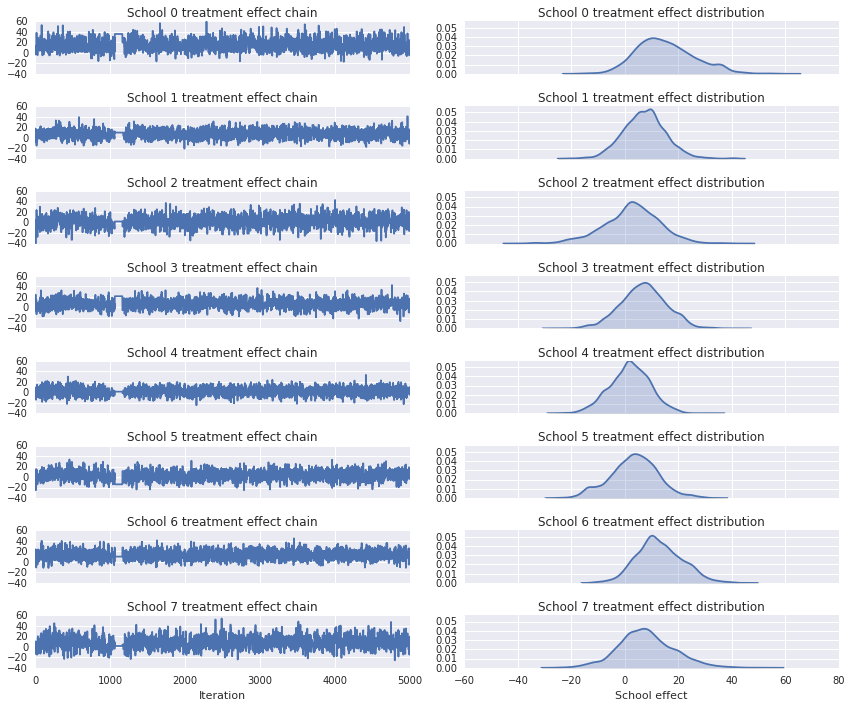

In [0]:
import warnings
warnings.filterwarnings('ignore')
fig, axes = plt.subplots(8, 2, sharex='col', sharey='col')
fig.set_size_inches(12, 10)
for i in range(num_schools):
  axes[i][0].plot(school_effects_samples[:,i])
  axes[i][0].title.set_text("School {} treatment effect chain".format(i))
  sns.kdeplot(school_effects_samples[:,i], ax=axes[i][1], shade=True)
  axes[i][1].title.set_text("School {} treatment effect distribution".format(i))
axes[num_schools - 1][0].set_xlabel("Iteration")
axes[num_schools - 1][1].set_xlabel("School effect")
fig.tight_layout()
plt.show()

In [0]:
# Compute the 95% interval for school_effects
school_effects_low = np.array([
    np.percentile(school_effects_samples[:, i], 2.5) for i in range(num_schools)
])
school_effects_med = np.array([
    np.percentile(school_effects_samples[:, i], 50) for i in range(num_schools)
])
school_effects_hi = np.array([
    np.percentile(school_effects_samples[:, i], 97.5)
    for i in range(num_schools)
])

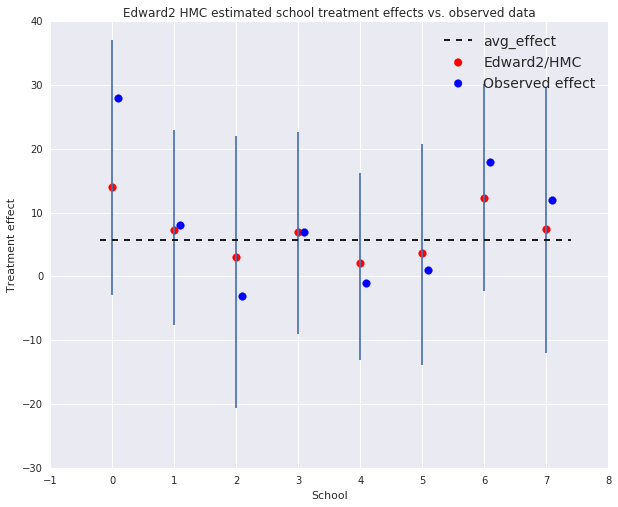

In [0]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
ax.scatter(np.array(range(num_schools)), school_effects_med, color='red', s=60)
ax.scatter(
    np.array(range(num_schools)) + 0.1, treatment_effects, color='blue', s=60)

avg_effect = trace['avg_effect'].mean()

plt.plot([-0.2, 7.4], [avg_effect, avg_effect], 'k', linestyle='--')

ax.errorbar(
    np.array(range(8)),
    school_effects_med,
    yerr=[
        school_effects_med - school_effects_low,
        school_effects_hi - school_effects_med
    ],
    fmt='none')

ax.legend(('avg_effect', 'Edward2/HMC', 'Observed effect'), fontsize=14)

plt.xlabel('School')
plt.ylabel('Treatment effect')
plt.title('Edward2 HMC estimated school treatment effects vs. observed data')
fig.set_size_inches(10, 8)
plt.show()

In [0]:
print("Inferred posterior mean: {0:.2f}".format(
    np.mean(school_effects_samples[:,])))
print("Inferred posterior mean se: {0:.2f}".format(
    np.std(school_effects_samples[:,])))

Inferred posterior mean: 7.30
Inferred posterior mean se: 10.18


# Criticism

Posterior inference can be done by simply passing a dictionary of variable names : values to  `model.get_posterior_fn()`. While it is called the posterior function, it can be used at any time to condition on any combination of the model variables and sample from the model.

In [0]:
trace_mean={
    "avg_effect": trace['avg_effect'].mean(0),
    "avg_stddev": trace['avg_stddev'].mean(0),
    "school_effects_standard": trace['school_effects_standard'].mean(0)
}
posterior = model.get_posterior_fn(states=trace_mean)

In [0]:
with tf.Session() as sess:
  posterior_predictive = sess.run(posterior().distribution.sample(5000))

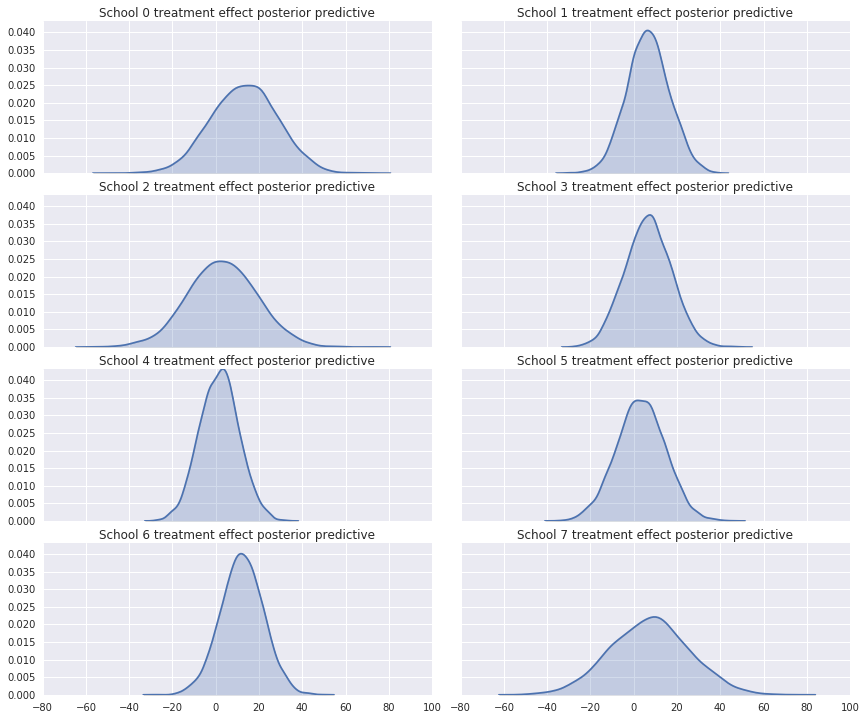

In [0]:
fig, axes = plt.subplots(4, 2, sharex=True, sharey=True)
fig.set_size_inches(12, 10)
fig.tight_layout()
for i, ax in enumerate(axes):
  sns.kdeplot(posterior_predictive[:, 2*i], ax=ax[0], shade=True)
  ax[0].title.set_text(
      "School {} treatment effect posterior predictive".format(2*i))
  sns.kdeplot(posterior_predictive[:, 2*i + 1], ax=ax[1], shade=True)
  ax[1].title.set_text(
      "School {} treatment effect posterior predictive".format(2*i + 1))
plt.show()

In [0]:
# The mean predicted treatment effects for each of the eight schools.# The m 
prediction = posterior_predictive.mean(axis=0)

In [0]:
treatment_effects - prediction

array([ 14.7491293 ,   1.3131609 ,  -6.10583878,   0.29395723,
        -2.70766521,  -2.28069067,   5.85145855,   4.52022409], dtype=float32)

In [0]:
residuals = treatment_effects - posterior_predictive

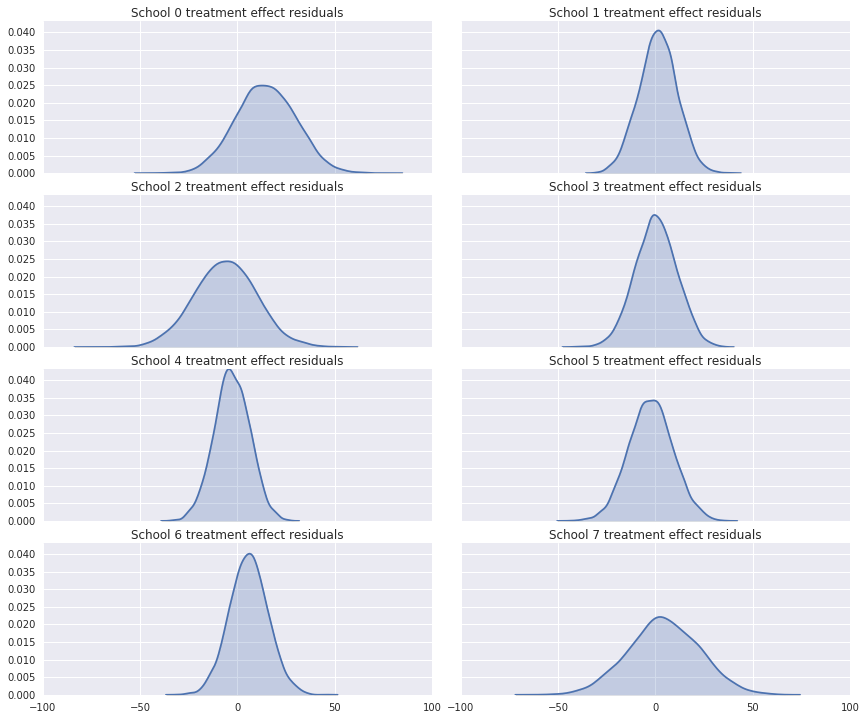

In [0]:
fig, axes = plt.subplots(4, 2, sharex=True, sharey=True)
fig.set_size_inches(12, 10)
fig.tight_layout()
for i, ax in enumerate(axes):
  sns.kdeplot(residuals[:, 2*i], ax=ax[0], shade=True)
  ax[0].title.set_text(
      "School {} treatment effect residuals".format(2*i))
  sns.kdeplot(residuals[:, 2*i + 1], ax=ax[1], shade=True)
  ax[1].title.set_text(
      "School {} treatment effect residuals".format(2*i + 1))
plt.show()

# Flexibility: sample using the model log joint directly

What if you want to use a custom sampling or optimization method? You can access the `target_log_prob_fn` by simply calling `model.target_log_prob_fn()` which returns a log joint function that takes the unobserved variable states as arguments.

This elides the necessity of explicitly defining and re-defining the log joint -- define the model, and everything follows.

In [0]:
# This is identical to 
# https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Eight_Schools.ipynb
# with one change:
# original: target_log_prob_fn=target_log_prob_fn
# here: target_log_prob_fn=model.target_log_prob_fn()
num_results = 5000
num_burnin_steps = 3000

states, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=[
        tf.zeros([], name='init_avg_effect'),
        tf.zeros([], name='init_avg_stddev'),
        tf.ones([num_schools], name='init_school_effects_standard'),
    ],
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=model.target_log_prob_fn(),
        step_size=0.4,
        num_leapfrog_steps=3))

avg_effect, avg_stddev, school_effects_standard = states

with tf.Session() as sess:
  [
      avg_effect_,
      avg_stddev_,
      school_effects_standard_,
      is_accepted_,
  ] = sess.run([
      avg_effect,
      avg_stddev,
      school_effects_standard,
      kernel_results.is_accepted,
  ])

school_effects_samples = (
    avg_effect_[:, np.newaxis] +
    np.exp(avg_stddev_)[:, np.newaxis] * school_effects_standard_)
num_accepted = np.sum(is_accepted_)
print('Acceptance rate: {}'.format(num_accepted / num_results))

Acceptance rate: 0.6286


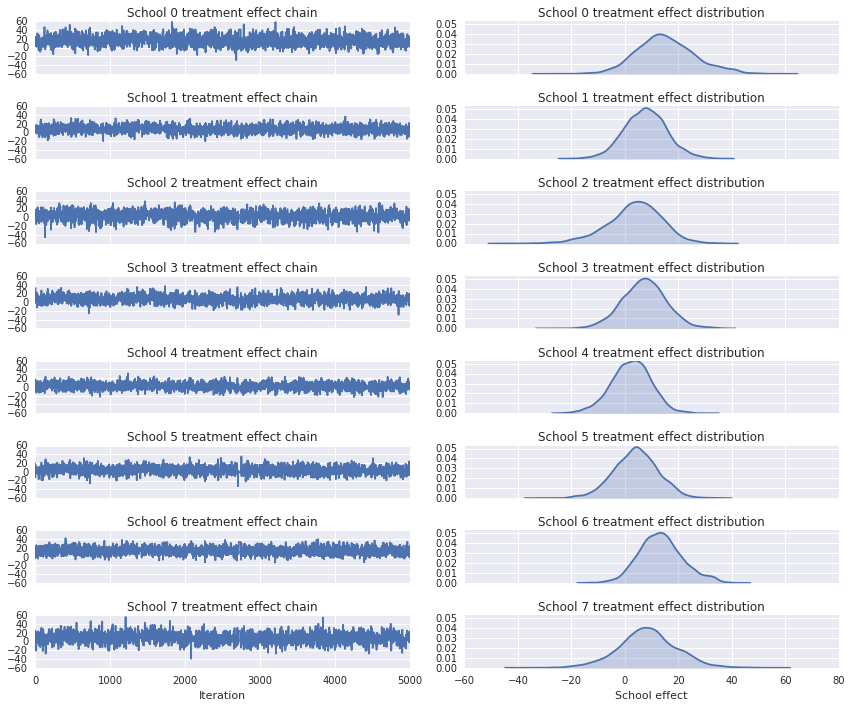

In [0]:
fig, axes = plt.subplots(8, 2, sharex='col', sharey='col')
fig.set_size_inches(12, 10)
for i in range(num_schools):
  axes[i][0].plot(school_effects_samples[:,i])
  axes[i][0].title.set_text("School {} treatment effect chain".format(i))
  sns.kdeplot(school_effects_samples[:,i], ax=axes[i][1], shade=True)
  axes[i][1].title.set_text("School {} treatment effect distribution".format(i))
axes[num_schools - 1][0].set_xlabel("Iteration")
axes[num_schools - 1][1].set_xlabel("School effect")
fig.tight_layout()
plt.show()

# Appendix: Bonus Example -- Tumors in Rats (Gelman BDA3 ch. 5, p.102-103)


Briefly: we use a hierarchical model to do meta-analysis of 70 experiments on tumors in rats. We want to learn a dose-response Binomial model in which the probability of a tumor is given by a parameter $\theta$. We partially-pool information across these studies.

In [0]:
num_tumors = np.array([
    0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 3, 2, 2,
    2, 2, 2, 2, 2, 2, 2, 1, 5, 2, 5, 2, 7, 7, 3, 3, 2, 9, 10, 4, 4, 4, 4, 4, 4,
    4, 10, 4, 4, 4, 5, 11, 12, 5, 5, 6, 5, 6, 6, 6, 6, 16, 15, 15, 9
], dtype=np.float32)
num_rats = np.array([
    20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 18, 18, 17, 20, 20, 20, 20, 19,
    19, 18, 18, 27, 25, 24, 23, 20, 20, 20, 20, 20, 20, 10, 49, 19, 46, 17, 49,
    47, 20, 20, 13, 48, 50, 20, 20, 20, 20, 20, 20, 20, 48, 19, 19, 19, 22, 46,
    49, 20, 20, 23, 19, 22, 20, 20, 20, 52, 46, 47, 24
], dtype=np.float32)

num_trials = num_tumors.shape[0]

In [0]:
class RatsModel(BaseModel):

  def __init__(self, num_trials, num_rats, num_tumors):
    super(BaseModel, self).__init__()
    self.num_trials = num_trials
    self.num_rats = num_rats
    self.num_tumors = num_tumors

  def call(self):
    mu = ed.Uniform(low=0., high=1., name="mu")
    nu = ed.Uniform(low=0., high=1., name="nu")

    alpha = mu / (nu * nu)
    beta = (1. - mu) / (nu * nu)

    thetas = ed.Beta(alpha, beta, sample_shape=self.num_trials, name="thetas")

    num_tumors = ed.Binomial(
        total_count=self.num_rats,
        probs=thetas,
        value=tf.zeros(self.num_trials),
        name="num_tumors")
    return num_tumors

In [0]:
rats_model = RatsModel(num_trials, num_rats, num_tumors)

In [0]:
rats_model.observed

{'num_rats': array([ 20.,  20.,  20.,  20.,  20.,  20.,  20.,  19.,  19.,  19.,  19.,
         18.,  18.,  17.,  20.,  20.,  20.,  20.,  19.,  19.,  18.,  18.,
         27.,  25.,  24.,  23.,  20.,  20.,  20.,  20.,  20.,  20.,  10.,
         49.,  19.,  46.,  17.,  49.,  47.,  20.,  20.,  13.,  48.,  50.,
         20.,  20.,  20.,  20.,  20.,  20.,  20.,  48.,  19.,  19.,  19.,
         22.,  46.,  49.,  20.,  20.,  23.,  19.,  22.,  20.,  20.,  20.,
         52.,  46.,  47.,  24.], dtype=float32),
 'num_trials': 70,
 'num_tumors': array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          3.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   2.,   1.,
          5.,   2.,   5.,   2.,   7.,   7.,   3.,   3.,   2.,   9.,  10.,
          4.,   4.,   4.,   4.,   4.,   4.,   4.,  10.,   4.,   4.,   4.,
          5.,  11.,  12.,   5.,   5.,   6.,   5.,   6.,   6.,   6.,   6.,
         16.,  15.

In [0]:
rats_model.unobserved

OrderedDict([('mu', TensorShape([])), ('nu', TensorShape([])), ('thetas', TensorShape([Dimension(70)]))])

In [0]:
%%time
trace = sample(
    rats_model, step_size=0.007, num_results=20000, num_burnin_steps=30000)

Acceptance rate: 0.6825
CPU times: user 3min 50s, sys: 1min 4s, total: 4min 54s
Wall time: 1min 3s


In [0]:
trace

{'mu': array([ 0.13621131,  0.14919996,  0.14919996, ...,  0.1653827 ,
         0.15704936,  0.15029475], dtype=float32),
 'nu': array([ 0.22894755,  0.25643843,  0.25643843, ...,  0.30614921,
         0.28908631,  0.29585737], dtype=float32),
 'thetas': array([[ 0.03820369,  0.05505243,  0.06088362, ...,  0.39380178,
          0.3433612 ,  0.22458574],
        [ 0.03352595,  0.05040256,  0.04917854, ...,  0.41271499,
          0.33252752,  0.22156732],
        [ 0.03352595,  0.05040256,  0.04917854, ...,  0.41271499,
          0.33252752,  0.22156732],
        ..., 
        [ 0.03573703,  0.11624624,  0.04754673, ...,  0.30633977,
          0.26184729,  0.29495266],
        [ 0.02742627,  0.10674512,  0.04129248, ...,  0.32037172,
          0.26268104,  0.2959362 ],
        [ 0.00670512,  0.13406998,  0.04245885, ...,  0.33862582,
          0.25996143,  0.31802705]], dtype=float32)}

In [0]:
alpha_ = trace['mu'] / (trace['nu']**2)
beta_ = (1. - trace['mu']) / (trace['nu']**2)

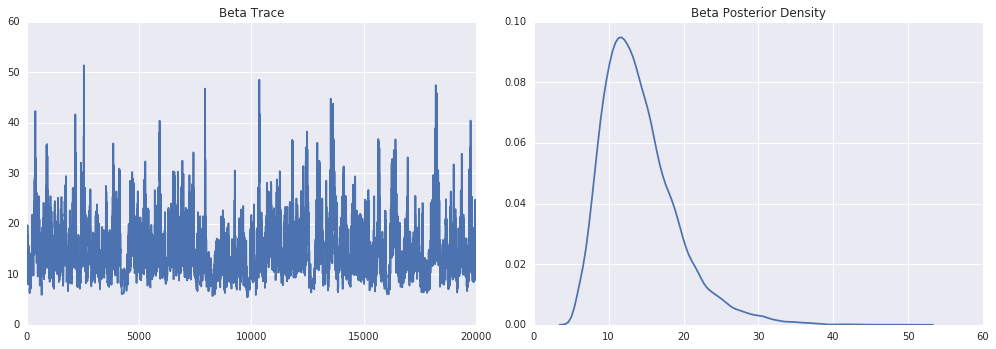

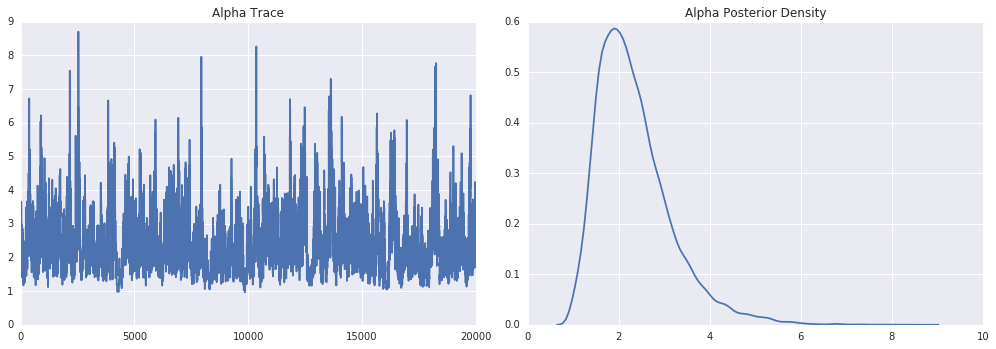

In [0]:
def plot_trace(trace, name):
  fig, axes = plt.subplots(1, 2, sharex='col', sharey='col')
  fig.set_size_inches(14, 5)
  axes[0].plot(trace)
  axes[0].title.set_text("{} Trace".format(name))
  sns.kdeplot(trace, ax=axes[1], shade=False)
  axes[1].title.set_text("{} Posterior Density".format(name))
  fig.tight_layout()
  plt.show()
  
plot_trace(beta_, "Beta")
plot_trace(alpha_, "Alpha")